## IF Notebook for RabbitMQ data

in this notebook ,we tried applying IF for anomaly detection using GridSearchCV for tuning parameters.



In [1]:
import pandas as pd
import pylab as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)warnings.filterwarnings('ignore')
import os

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix

%matplotlib inline

In [18]:
from config import *
#Paths defined in Config file python:

    #Saas Paths
        ##V1
            #raw_saas_v1         csv file containing original saas data V1 (not modified)    
        
            #proc_saas_min_v1    csv file containing processed saas data V1 (grouped by the min)
            #proc_saas_sec_v1    csv file containing processed saas data V1 (grouped by the sec)

        ##V2
            #raw_saas_v2         csv file containing original saas data V2 (not modified)  
                    
            #proc_saas_min_v2    csv file containing processed saas data V2 (grouped by the min)
            #proc_saas_sec_v2    csv file containing processed saas data V2 (grouped by the sec)
        
    #RabbitMQ paths         
        ##V1
            #raw_evts_v1
            
            #min_evts_v1 
            #sec_evts_v1 
            
        ##V2
            #raw_evts_V2  
            
            #min_evts_v2 
            #sec_evts_v2 
            
#function for loading data
def load_data(csv_path):
    return pd.read_csv(csv_path,\
                    parse_dates=['timestamp'] ,index_col=['timestamp'])#comment if timestamp indexing not wanted
                      

df = load_data(sec_evts_v1 )

df.head()

,routing_key,headers.name,headers.user_who_performed_action,count
timestamp,,,,
2019-01-28 14:38:49,connection.created,10.238.28.1:38128 -> 10.238.28.5:5672,bus-consolesaas,1
2019-01-28 14:38:50,channel.created,10.238.28.1:38128 -> 10.238.28.5:5672 (1),bus-consolesaas,72
2019-01-28 14:39:13,connection.created,10.238.28.1:38130 -> 10.238.28.5:5672,bus-consolesaas,1
2019-01-28 14:39:14,channel.created,10.238.28.1:38130 -> 10.238.28.5:5672 (1),bus-consolesaas,2
2019-01-28 14:39:14,channel.created,10.238.28.1:38130 -> 10.238.28.5:5672 (2),bus-consolesaas,2


## data splitting into train & test sets

In [19]:
from sklearn.model_selection import train_test_split

# Split the dataset in two equal parts
#train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(X_train)))
print('Testing Observations: %d' % (len(X_test)))

Observations: 10858
Training Observations: 8686
Testing Observations: 2172


## GridSearch for param tuning

In [20]:
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV

classifier = IsolationForest(contamination=0.1,  max_features=0.2)

mod = GridSearchCV(estimator=classifier, 
                   cv=5,
                   n_jobs=-1,
                   scoring='macro', 
                   refit="precision",
                   param_grid={'contamination': np.linspace(0.0001, 0.02, 30)})
#numpy.linspace(start=0.0001, stop=0.02, num=30)  30 is the number of samples to generate

#the "training part" :finds the coefficients for the coefficients for the equation specified via the algo
classifier.fit(X_train[['count']])

#Average anomaly score of X of the base classifiers.
#The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
#The measure of normality of an observation given a tree is the depth of the leaf containing this observation, 
#which is equivalent to the number of splittings required to isolate this point.
#In case of several observations n_left in the leaf, the average path length of a n_left samples isolation tree 
#is added.

# The Anomaly scores are calclated for each observation and stored in 'scores'
X_train['scores'] = classifier.decision_function(X_train[['count']])

# predict if a given value is an outlier or not; 1=inliner; -1=outlier
X_train['anomaly'] = classifier.predict(X_train[['count']]) 

X_train.loc[X_train['anomaly'] == 1, 'anomaly'] = 0  # if anomaly column value is 1, replace with 0
X_train.loc[X_train['anomaly'] == -1, 'anomaly'] = 1  # if anomaly column value is -1, replace with 1


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [21]:
classifier

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.1,
                max_features=0.2, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

0    7894
1     792
Name: anomaly, dtype: int64


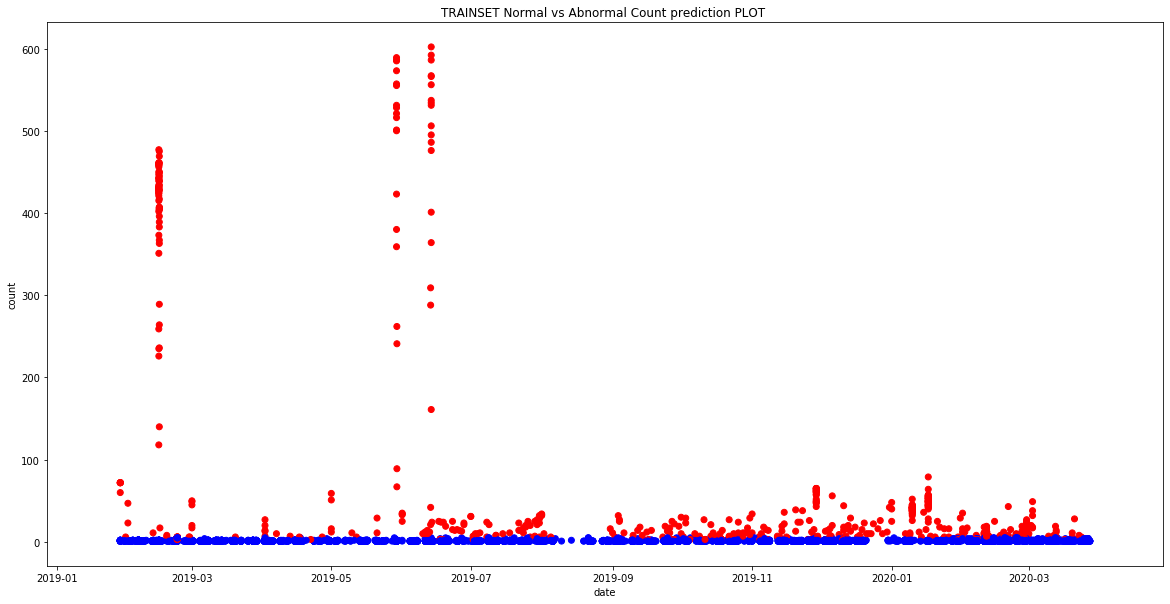

In [22]:
#Find the index of anomalies 
#here points classified -1 are anomalous
outlier=X_train.loc[X_train['anomaly']==1]
outlier_index=list(outlier.index)

print(X_train['anomaly'].value_counts()) 
# 0(not an anomaly)  and  1(anomaly)

plt.figure(figsize=(20,10))
plt.title('TRAINSET Normal vs Abnormal Count prediction PLOT ')
plt.scatter(x=X_train.index, y=X_train['count'], color=np.where(X_train['anomaly'] == 1, 'red', 'blue'))#if 1 red , if 0 blue aka noormal
plt.xlabel('date')
plt.ylabel('count')
plt.show()

C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

0    1972
1     200
Name: anomaly, dtype: int64


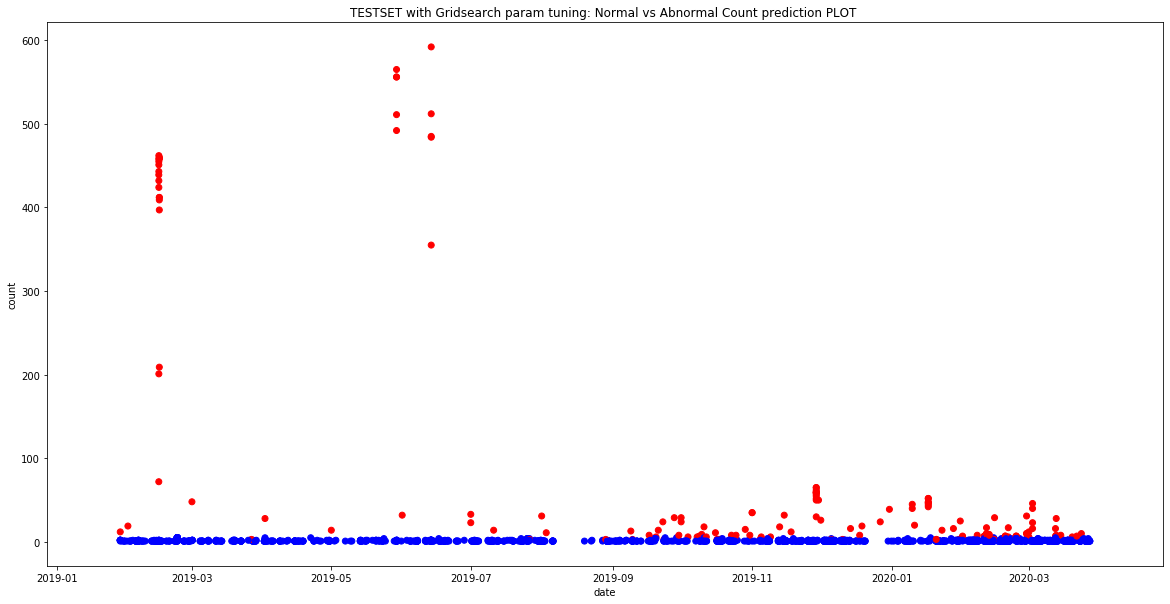

In [23]:
#predictions on the test set
# predict if a given value is an outlier or not; 1=inliner; -1=outlier
#X_test['anomaly'] = classifier.predict(X_test[['count']])

y_pred = classifier.predict(X_test[['count']])
X_test['anomaly']=y_pred

#Find the index of anomalies 
#here points classified -1 are anomalous
outliers=X_test.loc[X_test['anomaly']==-1]
outlier_index=list(outliers.index)

# The Anomaly scores are calclated for each observation and stored in 'scores_pred'
X_test['scores'] = classifier.decision_function(X_test[['count']])
#thelower the score the more abnormal ! (according to documentation)


X_test.loc[X_test['anomaly'] == 1, 'anomaly'] = 0  # if anomaly column value is 1, replace with 0
X_test.loc[X_test['anomaly'] == -1, 'anomaly'] = 1  # if anomaly column value is -1, replace with 1

print(X_test['anomaly'].value_counts()) 
# 0(not an anomaly)  and  1(anomaly)

plt.figure(figsize=(20,10))
plt.title('TESTSET with Gridsearch param tuning: Normal vs Abnormal Count prediction PLOT ')
plt.scatter(x=X_test.index, y=X_test['count'], color=np.where(X_test['anomaly'] == 1, 'red', 'blue'))#if 1 red , if 0 blue aka noormal
plt.xlabel('date')
plt.ylabel('count')
plt.show()


In [24]:
#print('Number of predicted anomalies within the Test Set  ', list(y_pred).count(-1) )
print('')
#print('Predictions ', y_pred)# -1 anomalie , 1 normal point

print('----------------------------------------')
anom = df.loc[pd.to_datetime(outlier_index)] 
anom 



----------------------------------------


,routing_key,headers.name,headers.user_who_performed_action,count
timestamp,,,,
2020-02-24 11:02:26,channel.created,10.238.28.9:52434 -> 10.238.28.5:5672 (1),bus-consolesaas,3
2020-01-28 00:02:14,channel.created,10.238.28.1:33460 -> 10.238.28.5:5672 (1),bus-consolesaas,16
2020-02-24 10:39:19,channel.created,10.238.28.9:52434 -> 10.238.28.5:5672 (1),bus-consolesaas,7
2020-02-01 00:02:17,channel.created,10.238.28.1:59786 -> 10.238.28.5:5672 (1),bus-consolesaas,6
2019-09-23 09:37:59,channel.created,10.238.28.3:55134 -> 10.238.28.5:5672 (1),bus-consolesaas,3
...,...,...,...,...
2019-06-13 14:42:19,channel.created,10.238.28.1:39510 -> 10.238.28.5:5672 (1),bus-consolesaas,355
2019-08-28 22:02:03,channel.created,10.238.28.3:41190 -> 10.238.28.5:5672 (1),bus-consolesaas,3
2020-02-11 14:39:55,channel.created,10.238.28.8:37780 -> 10.238.28.5:5672 (1),bus-consolesaas,9


In [25]:
print('----------------------------------------')
print(' Count of values predicted as Anomalies in the test set')
#
print(anom['count'].value_counts())



----------------------------------------
 Count of values predicted as Anomalies in the test set
3      75
6      30
7      11
8      10
9       7
       ..
565     1
47      1
492     1
44      1
512     1
Name: count, Length: 70, dtype: int64


#### Decision score:
Decision function: Average anomaly score of X of the base classifiers.

The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.

The measure of normality of an observation given a tree is the depth of the leaf containing this observation, 
which is equivalent to the number of splittings required to isolate this point. 
In case of several observations n_left in the leaf, the average path length of a n_left 
samples isolation tree is added.

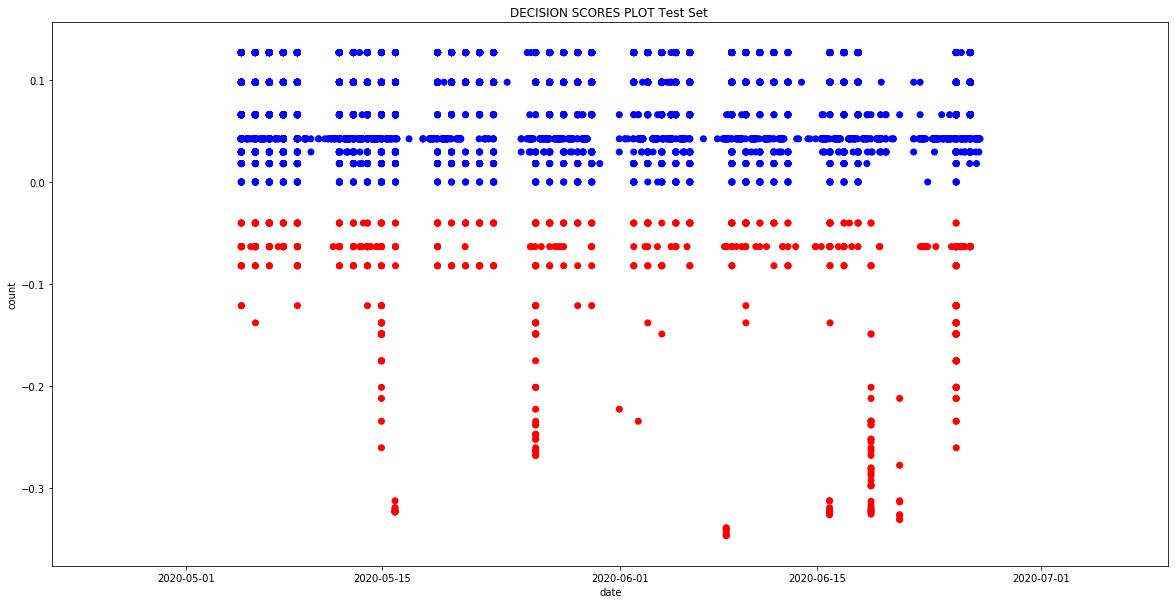

In [17]:
plt.figure(figsize=(20,10))
plt.title('DECISION SCORES PLOT Test Set ')
plt.scatter(x=X_test.index, y=X_test['scores'], color=np.where(X_test['anomaly'] == 1, 'red', 'blue'))#if 1 red , if 0 blue aka noormal
plt.xlabel('date')
plt.ylabel('count')
plt.show()